## Data Preprocessing
--- 
This notebook sets out to clean up the data

Mainly, we are looking to encode any string columns, and fill any NaN entries, and balance the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

import warnings
warnings.filterwarnings("ignore")

the raw data is available from: https://www.kaggle.com/competitions/home-credit-default-risk/data

In [17]:
data = pd.read_csv(r"raw_data/application_train.csv", index_col=0)


In [18]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,N

In [32]:
print(f"There are {data.isna().any().sum()} columns with NaN values")

There are 67 columns with NaN values


In [4]:
# Shape of the data
data.shape


(307511, 121)

---
### Exploration

In [5]:
cat = 0
num = 0

for i in data.columns:
    if data[i].dtype == "object":
        cat += 1
    else:
        num += 1
    
print(f"Cat cols: {cat}")
print(f"Num cols: {num}")

Cat cols: 16
Num cols: 105


In [35]:
data["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

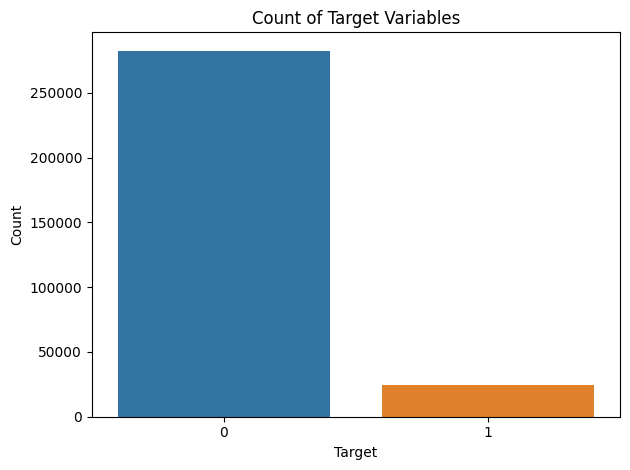

In [6]:
# distribution of target

sns.countplot(x="TARGET", data=data)

plt.title("Count of Target Variables")
plt.xlabel("Target")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("images/target_distribution.png")

---
### Encode the dataset

In [7]:
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

In [8]:
data = pd.get_dummies(data, columns=categorical_features)

---
### NaN entries

In [6]:
# remove any columns with more than 80% missing

data = data[data.columns[data.isnull().mean() < 0.80]]

In [7]:
# fill NaN values with linear regression

with_null = data.loc[:, data.isnull().any()]
without_null = data.loc[:, data.notnull().all()]
features_with_null = with_null.columns

for i, temp_feature in enumerate(features_with_null):
    print('For now, {} features have null data'.format(data.isnull().any().sum()))
    print('{} have {} null data'.format(temp_feature, data[temp_feature].isnull().sum()))
    
    temp_train = without_null.copy()
    temp_train[temp_feature] = with_null[temp_feature]
    
    new_train = temp_train.loc[temp_train[temp_feature].notnull(), :]
    new_test = temp_train.loc[temp_train[temp_feature].isnull(), :]
    
    temp_target = new_train[temp_feature].values
    
    new_train.drop([temp_feature], axis=1, inplace=True)
    new_test.drop([temp_feature], axis=1, inplace=True)
    
    print('-'*30,  '{} : Start Linear regression'.format(i), '-'*30)
    lr = LinearRegression()
    lr.fit(new_train, temp_target)
    
    temp_pred = lr.predict(new_test)

    new_train[temp_feature] = temp_target
    new_test[temp_feature] = temp_pred
    print('Prediction and concat')
    foo = pd.concat([new_train, new_test]).sort_index()
    
    data[temp_feature] = foo[temp_feature]
    
    del foo

For now, 61 features have null data
AMT_ANNUITY have 12 null data
------------------------------ 0 : Start Linear regression ------------------------------
Prediction and concat
For now, 60 features have null data
AMT_GOODS_PRICE have 278 null data
------------------------------ 1 : Start Linear regression ------------------------------
Prediction and concat
For now, 59 features have null data
OWN_CAR_AGE have 202929 null data
------------------------------ 2 : Start Linear regression ------------------------------
Prediction and concat
For now, 58 features have null data
CNT_FAM_MEMBERS have 2 null data
------------------------------ 3 : Start Linear regression ------------------------------
Prediction and concat
For now, 57 features have null data
EXT_SOURCE_1 have 173378 null data
------------------------------ 4 : Start Linear regression ------------------------------
Prediction and concat
For now, 56 features have null data
EXT_SOURCE_2 have 660 null data
-------------------------

In [8]:
# check and return for any columns with NaN
print(
    f"There are {len(data.columns[data.isna().any()])} columns containing NaN values"
)

There are 0 columns containing NaN values


---
### Check dtypes

In [9]:
# check that all float columns are supposed to be floats

float_columns = data.columns[data.dtypes == "float64"]

data[float_columns]

data[["DAYS_REGISTRATION", "CNT_FAM_MEMBERS"]] = data[["DAYS_REGISTRATION", "CNT_FAM_MEMBERS"]].astype(int)


In [53]:
# Lets also check that all the values in the dataframe as numerical

data.select_dtypes(exclude=["int64", "int32", "float64", "uint8"])

# this is just the index, so all is good

""
SK_ID_CURR
100002
100003
100004
100006
100007
...
456251
456252
456253


---
### Balance the dataset

In [10]:
# OVERSAMPLING
x = data.drop(["TARGET"], axis=1)
y = data.filter(["TARGET"], axis=1)

smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x, y)

oversampled_df = pd.DataFrame()
oversampled_df = pd.concat([x_resampled, y_resampled], axis=1)
# shuffle dataframe
oversampled_df = oversampled_df.sample(frac=1, random_state=42)

# oversampled_df.head()

In [ ]:
oversampled_df["TARGET"].value_counts(), oversampled_df.shape

---
### Correlations

In [12]:
def drop_correlated_columns(data, threshold, column_dropped=False):
    """
    This function drops any columns that have a high correlation to each other
    It will only leave one of the highly correlated columns
    """
    
    # Create correlation matrix
    corr_matrix = data.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the highly correlated columns
    for column in to_drop:
        data.drop(column, axis=1, inplace=True)
        
    if column_dropped:
        print(f"Columns dropped:\n{to_drop}")
    return data


In [14]:
# drop any columns with a high correlation

oversampled_df = drop_correlated_columns(oversampled_df, threshold=0.8, column_dropped=True)

Columns dropped:
['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA', 'EMERGENCYSTATE_MODE_No']


In [15]:
oversampled_df.shape

(565372, 203)

---
### Split the dataset train/test csv

In [16]:
def split_dataset(df, test_size=0.2):
    train_size = 1 - test_size
    train = df[:int(len(df)*train_size)]
    test = df[int(len(df)*train_size):]
    
    return train, test

In [54]:
oversampled_train, oversampled_test = split_dataset(oversampled_df, test_size=0.15)

print(f"Train dataset: {oversampled_train.shape}")
print(f"Test dataset: {oversampled_test.shape}")

Train dataset: (480566, 203)
Test dataset: (84806, 203)


---
### Export the datasets

In [ ]:
oversampled_df.head()

In [18]:
# export the cleaned data to a new file

oversampled_train.to_csv(r"processed_data/oversampled_train.csv")
oversampled_test.to_csv(r"processed_data/oversampled_test.csv")

oversampled_df.to_csv(r"processed_data/complete_data.csv")

print("Data exported")

Data exported
